# Deep Q-Learning

### Resources

- https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
- https://arxiv.org/pdf/1312.5602
- https://www.lesswrong.com/posts/kyvCNgx9oAwJCuevo/deep-q-networks-explained

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt

from collections import deque
from gymnasium.wrappers import FrameStack
from gymnasium.wrappers.frame_stack import LazyFrames
from stable_baselines3.common.atari_wrappers import (
    AtariWrapper,
    FireResetEnv,
)

gym.register_envs(ale_py)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Helper functions

In [4]:
def display_frame(frame, gray=False):
    if gray:
        plt.imshow(frame, cmap='gray')
    else:
        plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [5]:
def display_multiple_frames(frames):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i], cmap='gray')
        ax.axis('off')
    plt.show()

In [8]:
env_test = gym.make('PongNoFrameskip-v4', render_mode='rgb_array')

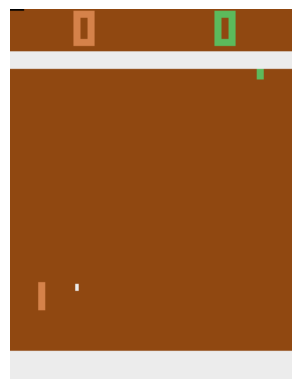

In [10]:
observation, _ = env_test.reset()
for _ in range(100):    
    action = env_test.action_space.sample()
    observation_prime, reward, terminated, truncated, _ = env_test.step(action)
display_frame(observation_prime)

In [6]:
class LazyFramesToNumpyWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env

    def observation(self, observation):
        if isinstance(observation, LazyFrames):
            return np.array(observation)
        return observation

In [7]:
def make_env(game, render='rgb_array'):
    env = gym.make(game, render_mode=render)
    env = AtariWrapper(env, terminal_on_life_loss=False, frame_skip=4)
    env = FrameStack(env, num_stack=4)
    env = LazyFramesToNumpyWrapper(env)
    if "FIRE" in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    return env

### Experience Replay

In [5]:
# some aspects of the replay buffer were inspired by https://www.lesswrong.com/posts/kyvCNgx9oAwJCuevo/deep-q-networks-explained
# since it was quite slow at the beginning

class ReplayBuffer:

    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self._buffer =  np.zeros((capacity,), dtype=object)
        self._position = 0
        self._size = 0

    def store(self, experience: tuple) -> None:
        idx = self._position % self.capacity
        self._buffer[idx] = experience
        self._position += 1
        self._size = min(self._size + 1, self.capacity)

    def sample(self, batch_size, device='cuda'):
        buffer = self._buffer[0:min(self._position-1, self.capacity-1)]
        batch = np.random.choice(buffer, size=[batch_size], replace=True)
        return (
            self.transform(batch, 0, shape=(batch_size, 4, 84, 84), dtype=torch.float32, device=device),
            self.transform(batch, 1, shape=(batch_size, 1), dtype=torch.int64, device=device),
            self.transform(batch, 2, shape=(batch_size, 1), dtype=torch.float32, device=device),
            self.transform(batch, 3, shape=(batch_size, 4, 84, 84), dtype=torch.float32, device=device),
            self.transform(batch, 4, shape=(batch_size, 1), dtype=torch.bool, device=device)
        )
        
    def transform(self, batch, index, shape, dtype, device):
        batched_values = np.array([val[index] for val in batch]).reshape(shape)
        batched_values = torch.as_tensor(batched_values, dtype=dtype, device=device)
        return batched_values

    def __len__(self):
        return self._size

    def __getitem__(self, index):
        return self._buffer[index]

    def __setitem__(self, index, value: tuple):
        self._buffer[index] = value
            

In [6]:
def load_buffer(preload, capacity, game):
    env = make_env(game)
    buffer = ReplayBuffer(capacity)

    observation, _ = env.reset()
    for _ in range(preload):    
        action = env.action_space.sample()

        observation_prime, reward, terminated, truncated, _ = env.step(action)
        buffer.store((
            observation.squeeze(), 
            action, 
            reward, 
            observation_prime.squeeze(), 
            terminated or truncated))
        observation = observation_prime

        done = terminated or truncated
        if done:
            observation, _ = env.reset()
    
    print(len(buffer))        
    return buffer, env

In [11]:
test_buffer, _ = load_buffer(100, 1000, 'PongNoFrameskip-v4')

100


(4, 84, 84)


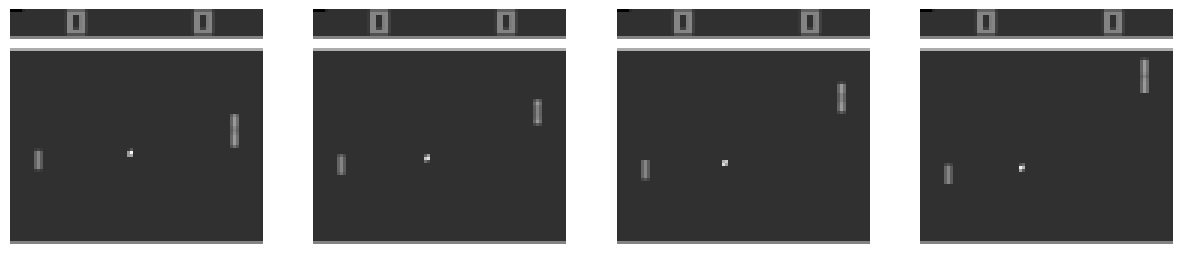

In [12]:
frame = test_buffer[10][3]
print(frame.shape)
display_multiple_frames(frame)

In [7]:
class DQN(nn.Module):

    def __init__(
        self,
        env,
        in_channels = 4,
        hidden_filters = [16, 32],
        start_epsilon = 0.99,
        max_decay = 0.1,
        decay_steps = 1000,
        *args,
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.start_epsilon = start_epsilon
        self.epsilon = start_epsilon
        self.max_decay = max_decay
        self.decay_steps = decay_steps
        self.env = env
        self.num_actions = env.action_space.n

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, hidden_filters[0], kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[0], hidden_filters[1], kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(hidden_filters[1] * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

        self.apply(self._init)

    def _init(self, m):
      if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
          nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x / 255.0)

    def epsilon_greedy(self, state, dim=1):
        rng = np.random.random()

        if rng < self.epsilon:
            action = self.env.action_space.sample()
            action = torch.tensor(action)
        else:
            with torch.no_grad():
                q_values = self(state)
            
            action = torch.argmax(q_values, dim=dim)

        return action

    def epsilon_decay(self, step):
        self.epsilon = self.max_decay + (self.start_epsilon - self.max_decay) * max(0, (self.decay_steps - step) / self.decay_steps)


In [8]:
class MetricTracker:
    def __init__(self, window_size=100):
        self.window_size = window_size
        self.rewards = deque(maxlen=window_size)
        self.episode_lengths = deque(maxlen=window_size)
        self.current_episode_reward = 0
        self.current_episode_length = 0
        
    def add_step_reward(self, reward):
        self.current_episode_reward += reward
        self.current_episode_length += 1
        
    def end_episode(self):
        self.rewards.append(self.current_episode_reward)
        self.episode_lengths.append(self.current_episode_length)
        self.current_episode_reward = 0
        self.current_episode_length = 0
        
    @property
    def avg_reward(self):
        return np.mean(self.rewards) if self.rewards else 0
        
    @property
    def avg_episode_length(self):
        return np.mean(self.episode_lengths) if self.episode_lengths else 0

Training procedure

In [15]:
def train(
    env, 
    name, 
    q_network, 
    target_network, 
    optimizer, 
    timesteps, 
    replay, 
    metrics, 
    train_freq, 
    batch_size, 
    gamma, 
    decay_start,
    C,
    best_avg_reward,
    scheduler_step,
    save_step=850000,
):
    loss_func = nn.MSELoss()
    start_time = time.time()
    episode_count = 0
    best_avg_reward = -float('inf')
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=0.5)
    
    obs, _ = env.reset()
    
    for step in range(1, timesteps+1):
        batched_obs = np.expand_dims(obs.squeeze(), axis=0)
        action = q_network.epsilon_greedy(torch.as_tensor(batched_obs, dtype=torch.float32, device=device)).cpu().item()
        obs_prime, reward, terminated, truncated, _ = env.step(action)

        
        replay.store((obs.squeeze(), action, reward, obs_prime.squeeze(), terminated or truncated))
        metrics.add_step_reward(reward)
        obs = obs_prime

        if step % train_freq == 0:
            observations, actions, rewards, observation_primes, dones = replay.sample(batch_size)
            
            with torch.no_grad():
                q_values_minus = target_network(observation_primes)
                boostrapped_values = torch.amax(q_values_minus, dim=1, keepdim=True)

            y_trues = torch.where(dones, rewards, rewards + gamma * boostrapped_values)
            y_preds = q_network(observations)

            loss = loss_func(y_preds.gather(1, actions), y_trues)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        scheduler.step()
            
        if step > decay_start: 
            q_network.epsilon_decay(step)
            target_network.epsilon_decay(step)
        
        if terminated or truncated:
            elapsed_time = time.time() - start_time
            steps_per_sec = step / elapsed_time
            metrics.end_episode()
            episode_count += 1
            
            obs, _ = env.reset()
            
            if metrics.avg_reward > best_avg_reward and step > save_step:
                best_avg_reward = metrics.avg_reward
                torch.save({
                    'step': step,
                    'model_state_dict': q_network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'avg_reward': metrics.avg_reward,
                }, f"models/{name}_dqn_best_{step}.pth")
                
            print(f"\rStep: {step:,}/{timesteps:,} | "
                    f"Episodes: {episode_count} | "
                    f"Avg Reward: {metrics.avg_reward:.1f} | "
                    f"Epsilon: {q_network.epsilon:.3f} | "
                    f"Steps/sec: {steps_per_sec:.1f}", end="\r")
            
        if step % C == 0:
            target_network.load_state_dict(q_network.state_dict())

In [16]:
TIMESTEPS = 6000000
LR = 2.5e-4
BATCH_SIZE = 64
C = 10000
GAMMA = 0.99
TRAIN_FREQ = 4
DECAY_START = 0 
FINAL_ANNEAL = 1000000

In [17]:
buffer_pong, env_pong = load_buffer(50000, 150000, game='PongNoFrameskip-v4')

50000


In [20]:
q_network_pong = DQN(env_pong, decay_steps=FINAL_ANNEAL).to(device)
target_network_pong = DQN(env_pong, decay_steps=FINAL_ANNEAL).to(device)
target_network_pong.load_state_dict(q_network_pong.state_dict())
optimizer_pong = torch.optim.Adam(q_network_pong.parameters(), lr=LR)

metrics = MetricTracker()

train(
    env=env_pong,
    q_network=q_network_pong, 
    name='pong',
    target_network=target_network_pong, 
    optimizer=optimizer_pong, 
    timesteps=TIMESTEPS, 
    replay=buffer_pong, 
    metrics=metrics, 
    train_freq=TRAIN_FREQ, 
    batch_size=BATCH_SIZE, 
    gamma=GAMMA, 
    decay_start=DECAY_START,
    C=C,
    best_avg_reward=-float('inf'),
    scheduler_step=4000000,
    save_step=5700000 # dont want to save too many models :P
)

In [9]:
def test(game, model, num_eps=2):
    env_test = make_env(game, render='human')

    q_network_trained = DQN(env_test)
    q_network_trained.load_state_dict(torch.load(model, weights_only=False)['model_state_dict'])
    q_network_trained.eval()
    q_network_trained.epsilon = 0.05
    
    
    rewards_list = []

    for episode in range(num_eps):
        print(f'Episode {episode}', end='\r', flush=True)
        obs, _ = env_test.reset()
        done = False
        total_reward = 0
        
        while not done:
            batched_obs = np.expand_dims(obs.squeeze(), axis=0)
            action = q_network_trained.epsilon_greedy(torch.as_tensor(batched_obs, dtype=torch.float32)).cpu().item()
                
            next_observation, reward, terminated, truncated, _ = env_test.step(action)
            total_reward += reward
            obs = next_observation

            done = terminated or truncated
            
        rewards_list.append(total_reward)

    env_test.close()
    print(f'Average episode reward achieved: {np.mean(rewards_list)}')

In [10]:
test('PongNoFrameskip-v4', 'models/pong_dqn_best_6M.pth')

C:\Users\garga\AppData\Local\Temp\ipykernel_36024\2204954719.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(observation)


Average episode reward achieved: 18.5


Not too bad! 

#### Now lets train Breakout

In [21]:
buffer_breakout, env_breakout = load_buffer(50000, 150000, 'BreakoutNoFrameskip-v4')

50000


In [22]:
TIMESTEPS = 4000000
LR = 2.5e-4
BATCH_SIZE = 64
C = 6000
GAMMA = 0.99
TRAIN_FREQ = 4
DECAY_START = 200000
FINAL_ANNEAL = 1000000

In [23]:
q_network_breakout = DQN(env_breakout, decay_steps=FINAL_ANNEAL).to(device)
target_network_breakout = DQN(env_breakout, decay_steps=FINAL_ANNEAL).to(device)
target_network_breakout.load_state_dict(q_network_breakout.state_dict())
optimizer_breakout = torch.optim.Adam(q_network_breakout.parameters(), lr=LR)

metrics_breakout = MetricTracker() 

train(
    env=env_breakout,
    name='breakout',
    q_network=q_network_breakout, 
    target_network=target_network_breakout, 
    optimizer=optimizer_breakout, 
    timesteps=TIMESTEPS, 
    replay=buffer_breakout, 
    metrics=metrics_breakout, 
    train_freq=TRAIN_FREQ, 
    batch_size=BATCH_SIZE, 
    gamma=GAMMA, 
    decay_start=DECAY_START,
    C=C,
    scheduler_step=3000000,
    best_avg_reward=-float('inf'),
    save_step=4700000
)

Lets test

In [12]:
test('BreakoutNoFrameskip-v4', 'models/breakout_dqn_best_4M.pth')

Average episode reward achieved: 28.0
